In [1]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
# %tensorflow_version 2.x
print('Installing from pip package...')
!pip install -qU ddsp==0.14.0

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
# from ddsp.colab import colab_utils
# from ddsp.colab.colab_utils import (
#     auto_tune, detect_notes, fit_quantile_transform, 
#     get_tuning_factor, download, play, record, 
#     specplot, upload, DEFAULT_SAMPLE_RATE)
import gin
# from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# IMPORTS MINE:
import sounddevice as sd
import time as stime


DEFAULT_SAMPLE_RATE = 16000 # general sound frequecy
sample_rate = DEFAULT_SAMPLE_RATE  # 16000 
sd.default.samplerate  = sample_rate # defult samplerate for sounddevice library
sd.default.channels = 1


# Helper Functions
DEFAULT_SAMPLE_RATE  = 16000
sample_rate = DEFAULT_SAMPLE_RATE  # 16000


print('Done!')

Installing from pip package...
Done!


In [2]:
### my Functions:
def playsound(inputsound):
    if len(inputsound) == 1:
        sd.play(inputsound[0], DEFAULT_SAMPLE_RATE)
        stime.sleep(len(inputsound[0])/DEFAULT_SAMPLE_RATE)
        sd.stop()
    else:
        sd.play(inputsound, DEFAULT_SAMPLE_RATE)
        stime.sleep(len(inputsound)/DEFAULT_SAMPLE_RATE)
        sd.stop()


def Myspecplot(inputsound):
    if len(inputsound)==1:
        plot = plt.figure(figsize=(4, 4))
        powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(inputsound[0], Fs=DEFAULT_SAMPLE_RATE)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        return plot   
    else:
        plot = plt.figure(figsize=(4, 4))
        powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(inputsound, Fs=DEFAULT_SAMPLE_RATE)
        plt.xlabel('Time')
        plt.ylabel('Frequency')
        return plot

    
# record sound and returen one arrry object
def recorder(duration=5):
    #duration = 5  # seconds
    # defult sample rate is 1600
    rec_audio = sd.rec(int(duration * sd.default.samplerate))
    sd.wait()
    audio = []
    for i in rec_audio:
        audio.append(i[0])
    audio = np.array(audio) 
    return audio

In [3]:
### Other Functinos
LD_RANGE = 120.0  # dB
import librosa

def pad_or_trim_to_expected_length(vector,
                                   expected_len,
                                   pad_value=0,
                                   len_tolerance=20,
                                   use_tf=False):
  """Make vector equal to the expected length.

  Feature extraction functions like `compute_loudness()` or `compute_f0` produce
  feature vectors that vary in length depending on factors such as `sample_rate`
  or `hop_size`. This function corrects vectors to the expected length, warning
  the user if the difference between the vector and expected length was
  unusually high to begin with.

  Args:
    vector: Numpy 1D ndarray. Shape [vector_length,]
    expected_len: Expected length of vector.
    pad_value: Value to pad at end of vector.
    len_tolerance: Tolerance of difference between original and desired vector
      length.
    use_tf: Make function differentiable by using tensorflow.

  Returns:
    vector: Vector with corrected length.

  Raises:
    ValueError: if `len(vector)` is different from `expected_len` beyond
    `len_tolerance` to begin with.
  """
  expected_len = int(expected_len)
  vector_len = int(vector.shape[-1])

  if abs(vector_len - expected_len) > len_tolerance:
    # Ensure vector was close to expected length to begin with
    raise ValueError('Vector length: {} differs from expected length: {} '
                     'beyond tolerance of : {}'.format(vector_len,
                                                       expected_len,
                                                       len_tolerance))
  # Pick tensorflow or numpy.
  lib = tf if use_tf else np

  is_1d = (len(vector.shape) == 1)
  vector = vector[lib.newaxis, :] if is_1d else vector

  # Pad missing samples
  if vector_len < expected_len:
    n_padding = expected_len - vector_len
    vector = lib.pad(
        vector, ((0, 0), (0, n_padding)),
        mode='constant',
        constant_values=pad_value)
  # Trim samples
  elif vector_len > expected_len:
    vector = vector[..., :expected_len]

  # Remove temporary batch dimension.
  vector = vector[0] if is_1d else vector
  return vector


def amplitude_to_db(amplitude, use_tf=False):
  """Converts amplitude to decibels."""
  lib = tf if use_tf else np
  log10 = (lambda x: tf.math.log(x) / tf.math.log(10.0)) if use_tf else np.log10
  amin = 1e-20  # Avoid log(0) instabilities.
  db = log10(lib.maximum(amin, amplitude))
  db *= 20.0
  return db


def stft_np(audio, frame_size=2048, overlap=0.75, pad_end=True):
  """Non-differentiable stft using librosa, one example at a time."""
  assert frame_size * overlap % 2.0 == 0.0
  hop_size = int(frame_size * (1.0 - overlap))
  is_2d = (len(audio.shape) == 2)

  if pad_end:
    n_samples_initial = int(audio.shape[-1])
    n_frames = int(np.ceil(n_samples_initial / hop_size))
    n_samples_final = (n_frames - 1) * hop_size + frame_size
    pad = n_samples_final - n_samples_initial
    padding = ((0, 0), (0, pad)) if is_2d else ((0, pad),)
    audio = np.pad(audio, padding, 'constant')

  def stft_fn(y):
    return librosa.stft(y=y,
                        n_fft=int(frame_size),
                        hop_length=hop_size,
                        center=False).T

  s = np.stack([stft_fn(a) for a in audio]) if is_2d else stft_fn(audio)
  return s



def compute_loudness(audio,
                     sample_rate=16000,
                     frame_rate=250,
                     n_fft=2048,
                     range_db=LD_RANGE,
                     ref_db=20.7,
                     use_tf=False):
  """Perceptual loudness in dB, relative to white noise, amplitude=1.

  Function is differentiable if use_tf=True.
  Args:
    audio: Numpy ndarray or tensor. Shape [batch_size, audio_length] or
      [batch_size,].
    sample_rate: Audio sample rate in Hz.
    frame_rate: Rate of loudness frames in Hz.
    n_fft: Fft window size.
    range_db: Sets the dynamic range of loudness in decibles. The minimum
      loudness (per a frequency bin) corresponds to -range_db.
    ref_db: Sets the reference maximum perceptual loudness as given by
      (A_weighting + 10 * log10(abs(stft(audio))**2.0). The default value
      corresponds to white noise with amplitude=1.0 and n_fft=2048. There is a
      slight dependence on fft_size due to different granularity of perceptual
      weighting.
    use_tf: Make function differentiable by using tensorflow.

  Returns:
    Loudness in decibels. Shape [batch_size, n_frames] or [n_frames,].
  """
  if sample_rate % frame_rate != 0:
    raise ValueError(
        'frame_rate: {} must evenly divide sample_rate: {}.'
        'For default frame_rate: 250Hz, suggested sample_rate: 16kHz or 48kHz'
        .format(frame_rate, sample_rate))

  # Pick tensorflow or numpy.
  lib = tf if use_tf else np

  # Make inputs tensors for tensorflow.
  audio = tf_float32(audio) if use_tf else audio

  # Temporarily a batch dimension for single examples.
  is_1d = (len(audio.shape) == 1)
  audio = audio[lib.newaxis, :] if is_1d else audio

  # Take STFT.
  hop_size = sample_rate // frame_rate
  overlap = 1 - hop_size / n_fft
  stft_fn = stft if use_tf else stft_np
  s = stft_fn(audio, frame_size=n_fft, overlap=overlap, pad_end=True)

  # Compute power.
  amplitude = lib.abs(s)
  power_db = amplitude_to_db(amplitude, use_tf=use_tf)

  # Perceptual weighting.
  frequencies = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
  a_weighting = librosa.A_weighting(frequencies)[lib.newaxis, lib.newaxis, :]
  loudness = power_db + a_weighting

  # Set dynamic range.
  loudness -= ref_db
  loudness = lib.maximum(loudness, -range_db)
  mean = tf.reduce_mean if use_tf else np.mean

  # Average over frequency bins.
  loudness = mean(loudness, axis=-1)

  # Remove temporary batch dimension.
  loudness = loudness[0] if is_1d else loudness

  # Compute expected length of loudness vector
  n_secs = audio.shape[-1] / float(
      sample_rate)  # `n_secs` can have milliseconds
  expected_len = int(n_secs * frame_rate)

  # Pad with `-range_db` noise floor or trim vector
  loudness = pad_or_trim_to_expected_length(
      loudness, expected_len, -range_db, use_tf=use_tf)
  return loudness


def squeeze(input_vector):
  """Ensure vector only has one axis of dimensionality."""
  if input_vector.ndim > 1:
    return np.squeeze(input_vector)
  else:
    return input_vector



In [4]:
import crepe
def compute_f0(audio, sample_rate, frame_rate, viterbi=True):
  """Fundamental frequency (f0) estimate using CREPE.

  This function is non-differentiable and takes input as a numpy array.
  Args:
    audio: Numpy ndarray of single audio example. Shape [audio_length,].
    sample_rate: Sample rate in Hz.
    frame_rate: Rate of f0 frames in Hz.
    viterbi: Use Viterbi decoding to estimate f0.

  Returns:
    f0_hz: Fundamental frequency in Hz. Shape [n_frames,].
    f0_confidence: Confidence in Hz estimate (scaled [0, 1]). Shape [n_frames,].
  """

  n_secs = len(audio) / float(sample_rate)  # `n_secs` can have milliseconds
  crepe_step_size = 1000 / frame_rate  # milliseconds
  expected_len = int(n_secs * frame_rate)
  audio = np.asarray(audio)

  # Compute f0 with crepe.
  _, f0_hz, f0_confidence, _ = crepe.predict(
      audio,
      sr=sample_rate,
      viterbi=viterbi,
      step_size=crepe_step_size,
      center=False,
      verbose=0)

  # Postprocessing on f0_hz
  f0_hz = pad_or_trim_to_expected_length(f0_hz, expected_len, 0)  # pad with 0
  f0_hz = f0_hz.astype(np.float32)

  # Postprocessing on f0_confidence
  f0_confidence = pad_or_trim_to_expected_length(f0_confidence, expected_len, 1)
  f0_confidence = np.nan_to_num(f0_confidence)   # Set nans to 0 in confidence
  f0_confidence = f0_confidence.astype(np.float32)
  return f0_hz, f0_confidence


In [22]:
#@title Record or Upload Audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 

record_or_upload = "Record"  #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =     5#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
    audio = recorder()
# else:
#   # Load audio sample here (.mp3 or .wav3 file)
#   # Just use the first file.
#   filenames, audios = upload()
#   audio = audios[0]
audio = audio[np.newaxis, :]


Extracting audio features...
Audio features took 45.4 seconds


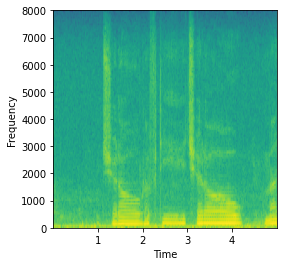

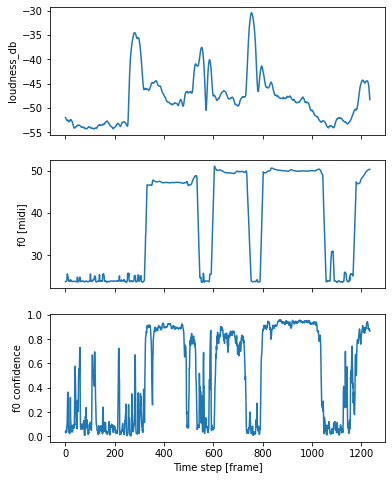

In [23]:
print('\nExtracting audio features...')
n_fft=2048
sample_rate=16000
frame_rate=250

# Plot.
Myspecplot(audio)
playsound(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_feats = {'audio': audio}
audio = squeeze(audio)
audio_feats['loudness_db'] = compute_loudness(audio, sample_rate, frame_rate, n_fft)
audio_feats['f0_hz'], audio_feats['f0_confidence'] = (compute_f0(audio, sample_rate, frame_rate))

audio_features = audio_feats
# audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')

In [24]:
#@title Load a model
#@markdown Run for ever new audio input
model = 'Violin' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'Upload your own (checkpoint folder as .zip)']
MODEL = model


# def find_model_dir(dir_name):
#   # Iterate through directories until model directory is found
#   for root, dirs, filenames in os.walk(dir_name):
#     for filename in filenames:
#       if filename.endswith(".gin") and not filename.startswith("."):
#         model_dir = root
#         break
#   return model_dir 

# if model in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
#   # Pretrained models.
#   PRETRAINED_DIR = '/content/pretrained'
#   # Copy over from gs:// for faster loading.
#   !rm -r $PRETRAINED_DIR &> /dev/null
#   !mkdir $PRETRAINED_DIR &> /dev/null
#   GCS_CKPT_DIR = 'gs://ddsp/models/timbre_transfer_colab/2020-11-06'
#   model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  
#   !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
#   model_dir = PRETRAINED_DIR
#   gin_file = os.path.join(model_dir, 'operative_config-0.gin')

# else:
#   # User models.
#   UPLOAD_DIR = '/content/uploaded'
#   !mkdir $UPLOAD_DIR
#   uploaded_files = files.upload()

#   for fnames in uploaded_files.keys():
#     print("Unzipping... {}".format(fnames))
#     !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
#   model_dir = find_model_dir(UPLOAD_DIR)
#   gin_file = os.path.join(model_dir, 'operative_config-0.gin')

gin_file = 'content/pretrained/operative_config-0.gin'  
model_dir = 'content/pretrained'

# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('DefaultPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Additive.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[0] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Additive.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'DefaultPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
# audio_features['audio'] = audio_features['audio'][:, :n_samples]
audio_features['audio'] = audio_features['audio'][0]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Loading dataset statistics from content/pretrained/dataset_statistics.pkl
Loading dataset statistics from pickle failed: No module named 'google.colab'.
Restoring model took 4.4 seconds


In [25]:
# time_steps = int(audio.shape[1] / hop_size)
audio_features

{'audio': array([-1.3759852e-07,  7.5794901e-07, -8.8817569e-07, ...,
        -8.1992950e-03, -1.1569154e-03,  7.5052977e-03], dtype=float32),
 'loudness_db': array([-52.008537, -52.11527 , -52.25226 , ..., -78.74575 , -86.03468 ,
        -98.24676 ], dtype=float32),
 'f0_hz': array([32.28215 , 32.33237 , 32.398304, ...,  0.      ,  0.      ,
         0.      ], dtype=float32),
 'f0_confidence': array([0.03509855, 0.02797708, 0.04601994, ..., 1.        , 1.        ,
        1.        ], dtype=float32)}


Skipping auto-adujst (box not checked or no dataset statistics found).


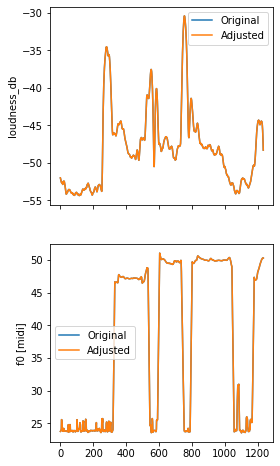

In [26]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true). 


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 1 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 20 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjsut the overall loudness (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = colab_utils.fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
    
    audio_features_mod['loudness_db'] = loudness_norm 

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2 
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])


Prediction took 3.2 seconds
Original
Resynthesis


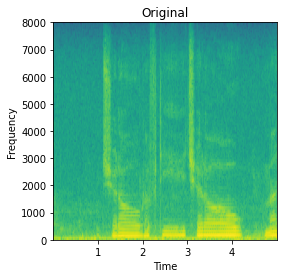

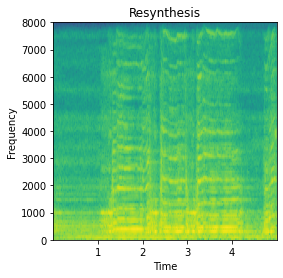

In [27]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
print('Original')
playsound(audio)

print('Resynthesis')
playsound(audio_gen)

Myspecplot(audio)
plt.title("Original")

Myspecplot(audio_gen)
_ = plt.title("Resynthesis")